### Sample Implementation of Shapelets for RIGHT_ELBOW_ANGLE

In [41]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Havent really used it but eh
from torch.utils.data import DataLoader

## Data Imports
from preprocess.features import *
from preprocess.timeseries import *
from preprocess.utils import *

## Model Imports
from model.shaplet_learner import *
from utils.config import *
from utils.trainer import *
from utils.weight_init import *
from ShapeletLearner.datasets.tsdataset import *


In [15]:
data_path = os.path.join(os.path.abspath(os.path.join(ROOT, "..", ".." )), "P0001_shooting_alt.csv") 
data = pd.read_csv(data_path)

In [16]:
data['RIGHT_ELBOW_ANGLE'] = data.apply(lambda row: angle_finder_shared(A = np.array([row['R_SHOULDER_x'], row['R_SHOULDER_y'], row['R_SHOULDER_z']]), 
                                                                       B = np.array([row['R_ELBOW_x'], row['R_ELBOW_y'], row['R_ELBOW_z']]), 
                                                                       C = np.array([row['R_WRIST_x'], row['R_WRIST_y'], row['R_WRIST_z']]), 
                                                                       D = np.array([row['R_ELBOW_x'], row['R_ELBOW_y'], row['R_ELBOW_z']])), axis=1)
ts_data, labels = DatasetTimeseries(data, 'RIGHT_ELBOW_ANGLE')

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional

import torch

def DTW_calc(ts1, ts2):
    """
    Computes the DTW similarity (for univariate time series) between two time series.
    Handles one input having batch size 1 for broadcasting (shapelet of shape (1, len_shapelet)).
    
    Parameters:
    ts1: Tensor of shape (batch_size1, time_steps1) or (1, time_steps1) (shapelet)
    ts2: Tensor of shape (batch_size2, time_steps2) (time series segment)
    
    Returns:
    dtw_dist: Tensor of shape (batch_size,) containing the DTW distance for each batch.
    """
    # Compute the cost matrix
    cost_mat = cost_matrix(ts1, ts2)

    # Return the square root of the final element in the cost matrix (total DTW cost for each batch)
    return torch.sqrt(cost_mat[:, -1, -1])

def euclidean_diff(ts1, ts2):
    """
    Calculates the squared Euclidean distance between two points (or vectors) from two univariate time series.
    Handles broadcasting if one input has batch size 1 (shapelet of shape (1,)).
    
    Parameters:
    ts1: Tensor of shape (batch_size,)
    ts2: Tensor of shape (batch_size,) or (1,)
    
    Returns:
    dist: Tensor of shape (batch_size,) containing the squared Euclidean distance for each batch.
    """
    return (ts1 - ts2) ** 2

def cost_matrix(ts1, ts2):
    """
    Computes the cost matrix for DTW with differentiable operations.
    Handles one input having batch size 1 (for shapelet broadcasting), supports univariate time series.
    
    Parameters:
    ts1: Tensor of shape (batch_size, time_steps1) or (1, time_steps1)
    ts2: Tensor of shape (batch_size, time_steps2)
    
    Returns:
    cum_sum: Tensor of shape (batch_size, time_steps1, time_steps2) containing the cumulative sum for each batch.
    """
    batch_size1, ts1_size = ts1.shape 
    batch_size2, ts2_size = ts2.shape


    batch_size = max(batch_size1, batch_size2)


    cum_sum = torch.zeros((batch_size, ts1_size + 1, ts2_size + 1), device=ts1.device)
    cum_sum[:, 1:, 0] = float('inf')
    cum_sum[:, 0, 1:] = float('inf')


    for i in range(1, ts1_size + 1):
        for j in range(1, ts2_size + 1):
            cost = euclidean_diff(ts1[:, i - 1], ts2[:, j - 1])
            cum_sum[:, i, j] = cost + torch.min(torch.stack([
                cum_sum[:, i - 1, j],   # Insertion
                cum_sum[:, i, j - 1],   # Deletion
                cum_sum[:, i - 1, j - 1]  # Match
            ], dim=0), dim=0)[0]

    return cum_sum[:, 1:, 1:]



In [193]:
class ShapletLearner(nn.Module):
    def __init__(self, num_shapelet, len_shapelet, input_size, num_classes, alpha_precision, kmeans_centroids, type_dist):
        super().__init__()

        assert input_size % len_shapelet  == 0, "The input size may not be compatiable with the Timeseries size"
        assert type_dist in ["euclid", "DTW"]
         
        self.L = num_shapelet ## Using the paper's terminalogy
        self.K = len_shapelet

        self.Q = input_size
        self.I = num_classes

        self.alpha = alpha_precision
        self.type_dist = type_dist

        if kmeans_centroids is not None: ## TODO Include method directly
            assert kmeans_centroids.shape == (num_shapelet, len_shapelet), \
                "KMeans centroids must have the shape (num_shapelets, len_shapelet)."
            self.shapelets = nn.ParameterList(
                [nn.Parameter(torch.tensor(centroid, dtype=torch.float32).unsqueeze(0)) for centroid in kmeans_centroids]
            )
        else:
            self.shapelets = nn.ParameterList(nn.Parameter(torch.randn(self.K)) for _ in range(num_shapelet))
        
       
        self.fc1 = nn.Linear(self.L, 2)

        self.loss_fn = torch.nn.CrossEntropyLoss() ## This is what they used not sure why not BCE with logit but eh

    def _compute_shapelet_dist(self, ts):

        shapelet_distances = [] 
        if self.type_dist == "euclid":

            for shapelet in self.shapelets:
                num_segments = self.Q - self.K + 1
                distances = []
                for j in range(num_segments):
                    segment = ts[:, j:j+self.K] 
                    segment = segment
                    dist = torch.mean((segment - shapelet)**2, dim = 1)
                    if torch.isnan(dist).any():
                        print("NaN detected in distance calculation")
                    distances.append(dist)
                distances = torch.stack(distances, dim = 1)

                hard_min, _ = torch.min(distances, dim=1)
                if torch.isnan(hard_min).any():
                    print("NaN detected in min operation") 
                shapelet_distances.append(hard_min)


            result =  torch.stack(shapelet_distances, dim = 1) 
        
        
        elif self.type_dist == "DTW":
            for shapelet in self.shapelets:
                num_segments = self.Q - self.K + 1
                distances = []
                for j in range(num_segments):
                    segment = ts[:, j:j+self.K]
                    dist = DTW_calc(segment, shapelet)
                    if torch.isnan(dist).any():
                        print("Nan Detected in DTW distance calculation")
                    distances.append(dist)
                distances = torch.stack(distances, dim=1)
                hard_min, _ = torch.min(distances, dim=1)
                if torch.isnan(hard_min).any():
                    print("NaN detected in DTW min")
                shapelet_distances.append(hard_min)

            
            result = torch.stack(shapelet_distances, dim=1)
        return result

    def forward(self, ts):
        ts = ts.float()
        shaplet_distances = self._compute_shapelet_dist(ts)
        output = self.fc1(shaplet_distances)
        return output
    
    def loss(self, pred, labels):
        return self.loss_fn(pred, labels)
    


In [194]:
def train_shaplet_model(model, train_loader, optimizer, epochs = 10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for time_series, labels in train_loader:
            time_series, labels = time_series.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(time_series)
            loss = model.loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader)}')
        

In [195]:
alpha = None
trial = TSDataset(ts_data = ts_data, labels=labels)
train_loader = DataLoader(trial, batch_size=32, shuffle=True)

kmeans_centroids = shapelet_initialization(ts_data, num_shapelets, shapelet_lengths)

model = ShapletLearner(num_shapelets, shapelet_lengths, input_size, num_classes, alpha, kmeans_centroids, type_dist= "euclid") ## Add higher regularization after the new method
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_shaplet_model(model, train_loader, optimizer, epochs)

Epoch [1/100], Loss: 2.9051676988601685
Epoch [2/100], Loss: 1.9831349402666092
Epoch [3/100], Loss: 1.8090351223945618
Epoch [4/100], Loss: 1.5866778790950775
Epoch [5/100], Loss: 1.3292222619056702
Epoch [6/100], Loss: 1.1475953608751297
Epoch [7/100], Loss: 1.068009003996849
Epoch [8/100], Loss: 0.9355888366699219
Epoch [9/100], Loss: 0.8911423832178116
Epoch [10/100], Loss: 0.8499580174684525
Epoch [11/100], Loss: 0.8137171566486359
Epoch [12/100], Loss: 0.7474128305912018
Epoch [13/100], Loss: 0.7050714567303658
Epoch [14/100], Loss: 0.6636979430913925
Epoch [15/100], Loss: 0.6319134086370468
Epoch [16/100], Loss: 0.6399479433894157
Epoch [17/100], Loss: 0.6177882254123688
Epoch [18/100], Loss: 0.584868460893631
Epoch [19/100], Loss: 0.6197196990251541
Epoch [20/100], Loss: 0.5803786069154739
Epoch [21/100], Loss: 0.5982509478926659
Epoch [22/100], Loss: 0.5757777094841003
Epoch [23/100], Loss: 0.5786026418209076
Epoch [24/100], Loss: 0.5807663351297379
Epoch [25/100], Loss: 0.594

In [201]:
import matplotlib.pyplot as plt


def plot_shapelets(shapelets, timeseries):
    """
    Plot the top k best Learned Shapelets for a given timeseries that contribute to a specific outcome that we find contributes 
    the most. 
    
    Arguments:
        shapelets: List of learned shapelets.
        time_series: List of time series data.
    """

    fig, axes = plt.subplots(10, 1, figsize = (10, 32))
    
    for i,shapelet in enumerate(shapelets):
        shapelet_length = len(shapelet)
        
        distances = []
        for j in range(231):
            segment = timeseries[:, j:j+shapelet_length]
            dist = torch.mean(torch.sqrt((segment - shapelet)**2))
            distances.append((dist.item(), j))
        
        distances = sorted(distances, key = lambda x: x[0])
        closest_match = distances[0]
        print(closest_match)

        start_idx = closest_match[1]

        padded_shapelet = torch.cat([
        torch.full((start_idx,), float('nan')), 
        shapelet.squeeze(0),                    
        torch.full((len(timeseries.squeeze()) - (start_idx + shapelet_length),), float('nan'))  
        ])
        axes[i].plot(timeseries.squeeze().cpu().numpy(), label=f"Time Series", color="b")
        axes[i].plot(padded_shapelet.cpu().detach().numpy(), 
                 color="g", linewidth=2, label=f"Shapelet {i+1}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()




(18.40982131958008, 85)
(1.3608062744140625, 26)
(1.3800025939941407, 93)
(18.898052978515626, 69)
(4.984104919433594, 48)
(21.406411743164064, 50)
(2.415234375, 77)
(1.5096011494293151, 167)
(2.1663139343261717, 62)
(0.5116241455078125, 203)


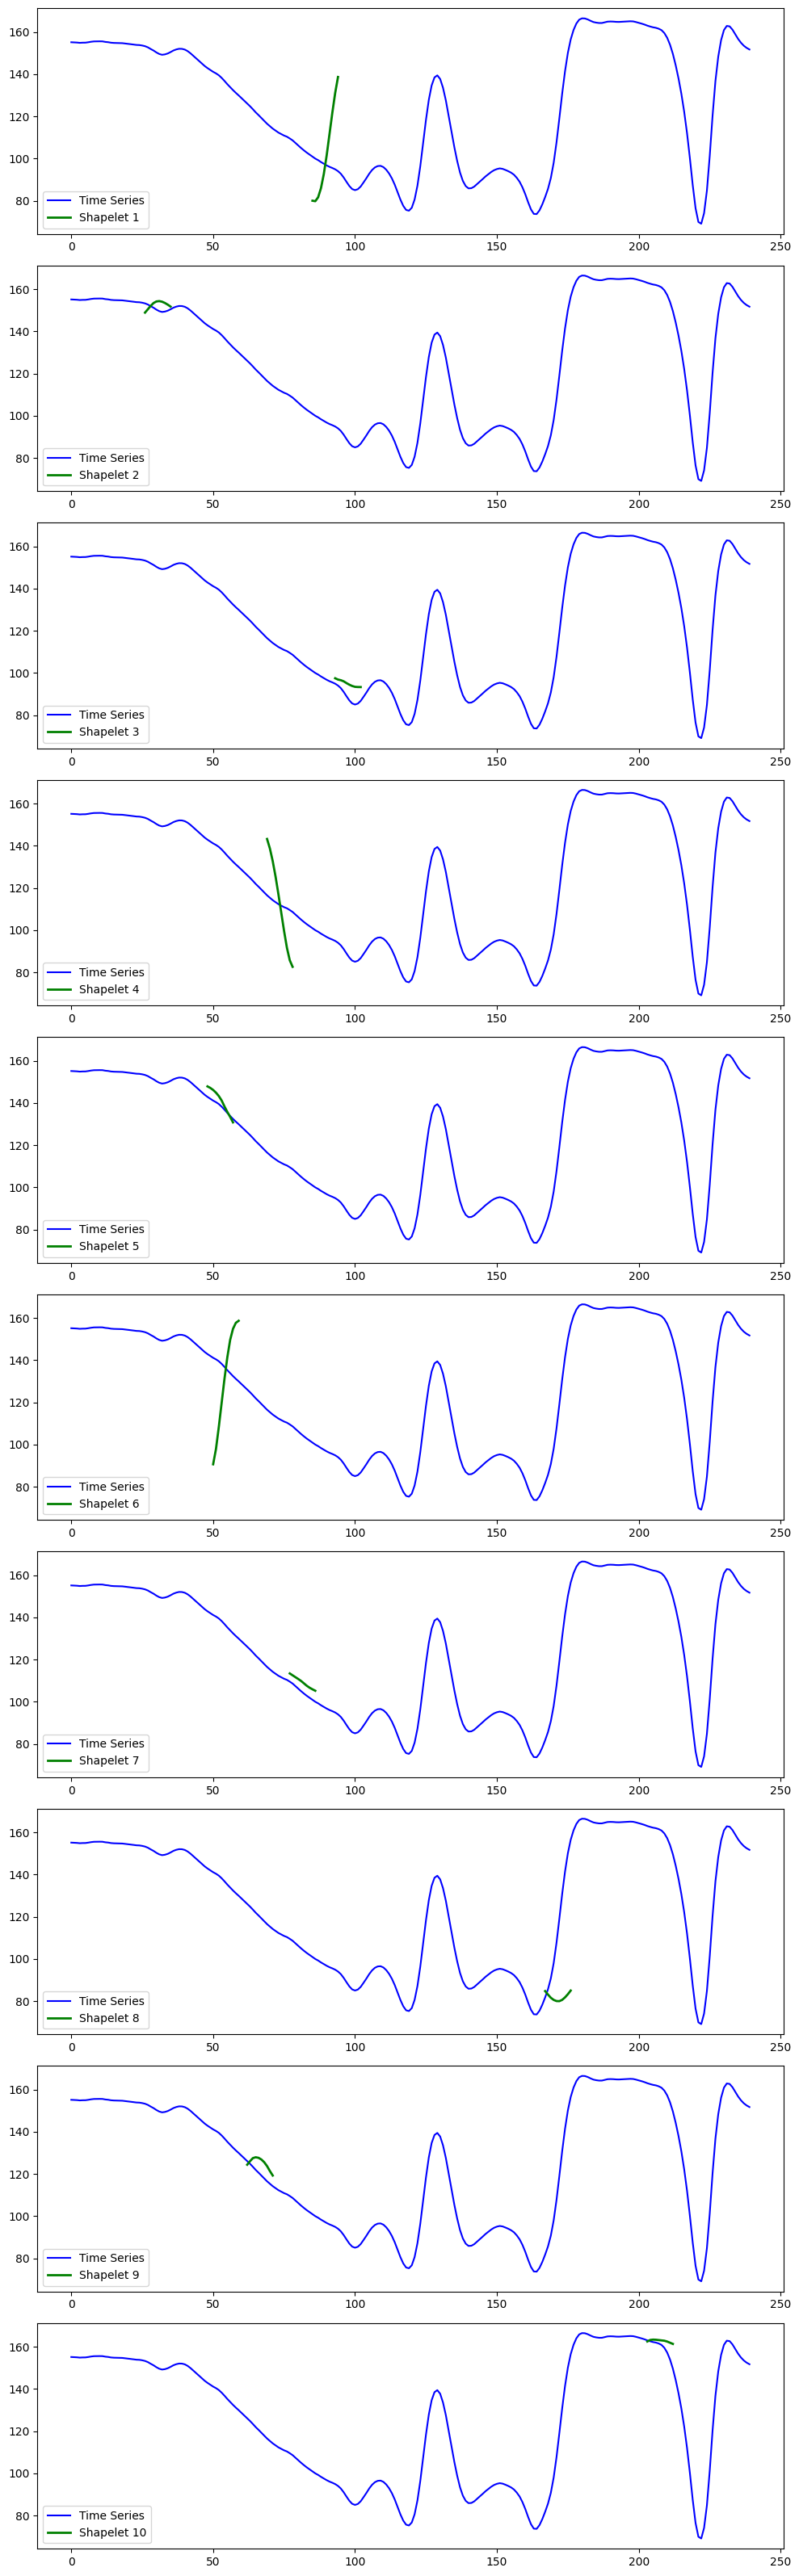

In [203]:
plot_shapelets(model.shapelets, ts_data[0, :].unsqueeze(0))

(18.40982131958008, 69)
(1.3608062744140625, 0)
(1.3800025939941407, 99)
(18.898052978515626, 56)
(4.984104919433594, 39)
(21.406411743164064, 40)
(2.415234375, 62)
(1.5151951963952939, 108)
(2.1663139343261717, 120)
(0.5175857862263286, 172)


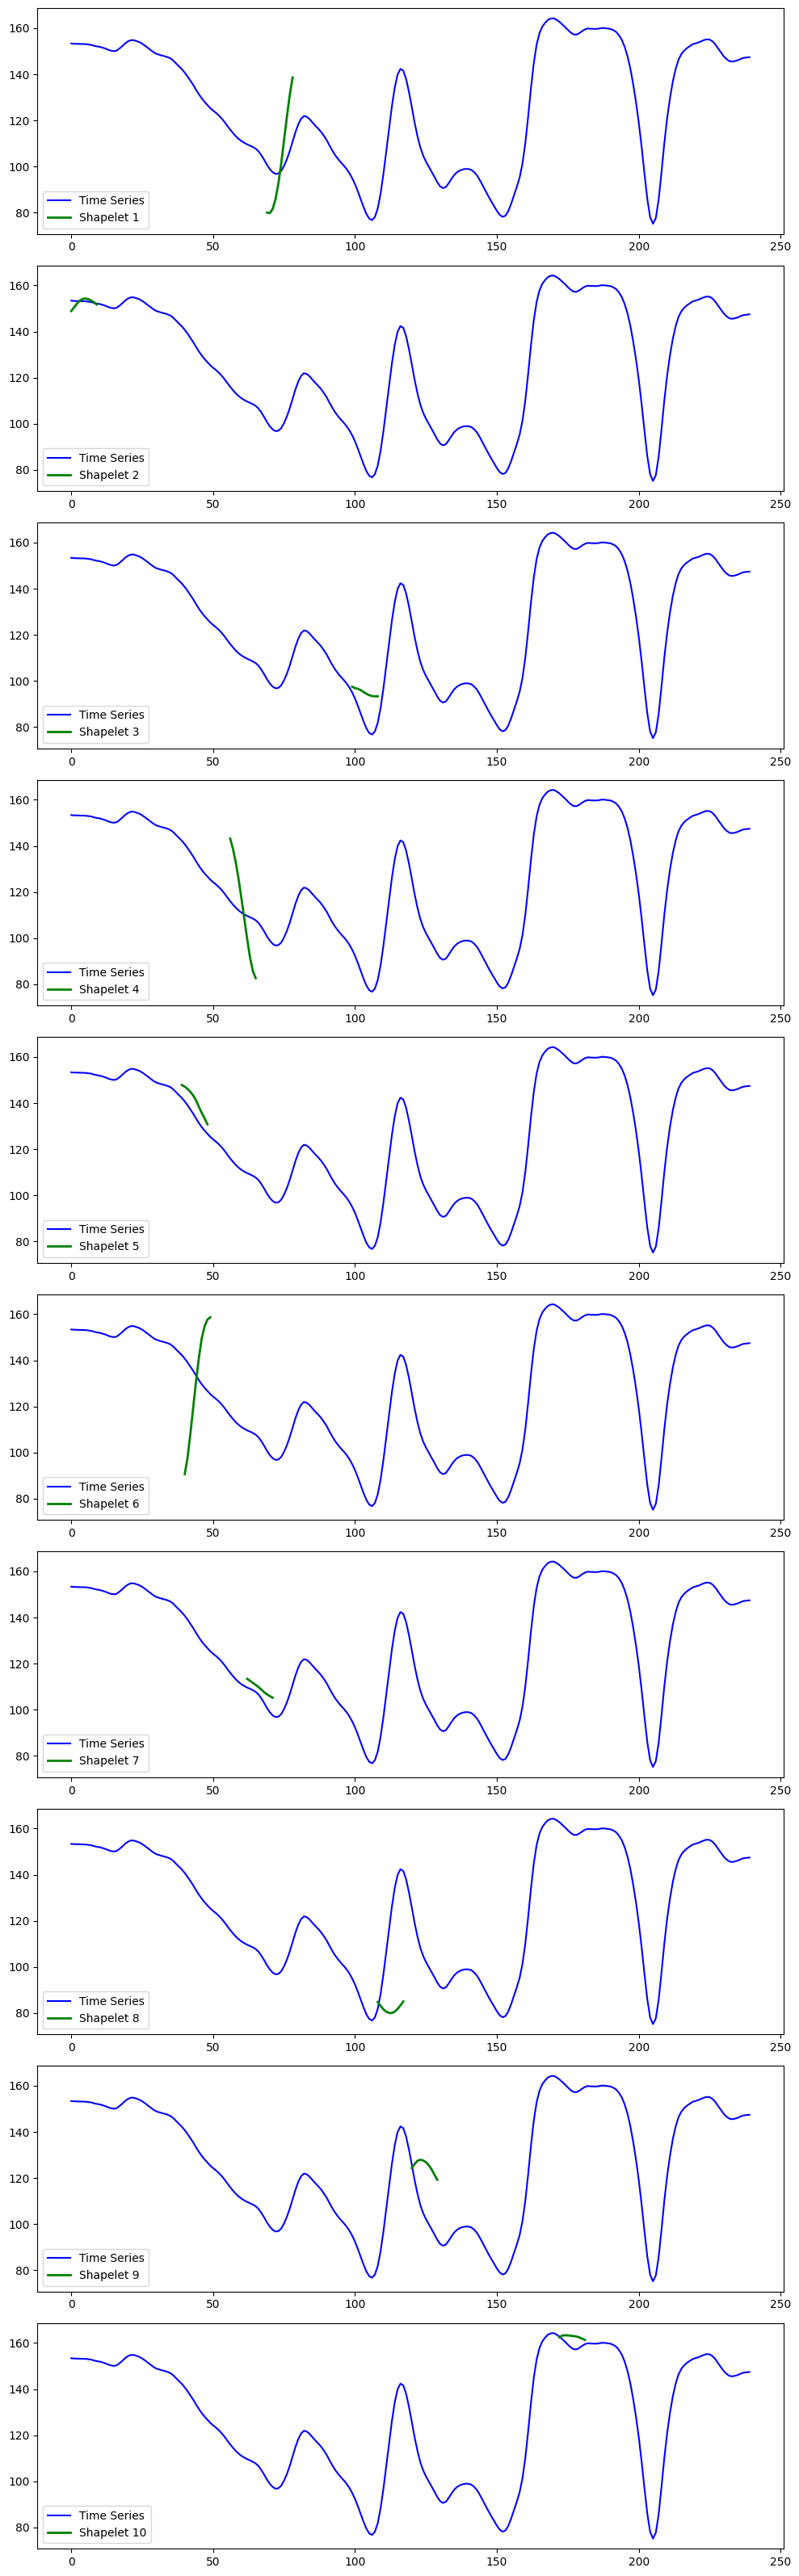

In [204]:
plot_shapelets(model.shapelets, ts_data[1, :].unsqueeze(0))